#### Read

In [1]:
filename = "declaration-of-independence"
fd = open("{}.txt".format(filename), "r")
text = fd.read()
fd.close()

#### Pre-process

In [2]:
import re
# Remove punctuation.
# Notable exclusions: prime(')
# TODO: Treat periods as a separate, special token.
document = re.sub("[.,-;:\"]+", "", text)
normal_tokens = document.split()
tokens = [token.lower() for token in normal_tokens]
print("Terms:", len(tokens))
vocab = list(set(tokens))
vocab.sort()
m = len(vocab)
print("Vocabulary:", m)

Terms: 1316
Vocabulary: 534


#### Co-occurrence Matrix

In [3]:
import numpy as np
# r = Window radius: Terms to the left or right of a
#  given term defined as being in the same "context".
r = 8
co = np.zeros((m, m))
def occur(co, token, other, vocab):
    i = vocab.index(token)
    j = vocab.index(other)
    co[i, j] += 1
for t in range(len(tokens)):
    token = tokens[t]
    # Count co-occurrences to the left of this term.
    for other in tokens[max(0, t - r):t]:
        occur(co, token, other, vocab)
    # Count co-occurrences to the right of this term.
    for other in tokens[t + 1:min(t + 1 + r, len(tokens))]:
        occur(co, token, other, vocab)

# Gradient Descent

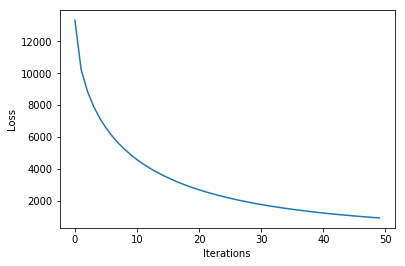

In [4]:
import matplotlib.pyplot as plt
vector_dim = 200
iterations = 50
co_max = np.max(co)
weight_alpha = 3/4
learning_rate = .01

center_embedding = np.random.uniform(low=-1, high=1, size=(m,vector_dim))
context_embedding = np.random.uniform(low=-1, high=1, size=(m,vector_dim))

center_bias = np.random.uniform(low=-1, high=1, size=(m))
context_bias = np.random.uniform(low=-1, high=1, size=(m))

##### Variable update historical arrays
center_history = np.zeros((m,vector_dim)) + .1
context_history = np.zeros((m, vector_dim)) + .1
bias_center_history = np.zeros(m) + .1
bias_context_history = np.zeros(m) + .1

def weight_fun(x, co_max, alpha):
    if x >= co_max:
        return 1
    return np.power(x/co_max,alpha)

losses = []

for iters in range(iterations):
    global_loss = 0
    for i in range(m):
        for j in range(m):
            count = co[i,j]
            if count != 0:
                center = center_embedding[i,:]
                context = context_embedding[j,:]
                b1 = center_bias[i]
                b2 = context_bias[j]
                weight = weight_fun(count, co_max, weight_alpha)
                inner_loss = np.dot(center,context) + b1 + b2 - np.log(count)
                loss = weight * np.square(inner_loss)
                global_loss += loss

                ### Compute Gradients
                grad_center = weight * inner_loss * context
                grad_context = weight * inner_loss * center
                grad_bias_center = weight * inner_loss
                grad_bias_context = weight * inner_loss

                center_embedding[i,:] -=  learning_rate * (grad_center  / np.sqrt(center_history[i,:]))
                context_embedding[j,:] -= learning_rate * (grad_context / np.sqrt(context_history[j,:]))
                center_bias[i] -=  learning_rate * (grad_bias_center / np.sqrt(bias_center_history[i]))
                context_bias[j] -= learning_rate * (grad_bias_context / np.sqrt(bias_context_history[j]))

                center_history[i,:] += np.square(grad_center)
                context_history[j,:] += np.square(grad_context)
                bias_center_history[i] += np.square(grad_bias_center)
                bias_context_history[j] += np.square(grad_bias_context)
    losses.append(global_loss)
            

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

#### Save vocabulary and embeddings

In [5]:
with open("{}.vocab".format(filename), "w") as fd_vocab:
    for i in range(m):
        fd_vocab.write("{}\n".format(vocab[i]))

In [6]:
with open("{}.center".format(filename), "w") as fd_center:
    for i in range(m):
        for j in range(vector_dim):
            fd_center.write("{} ".format(center_embedding[i][j]))
        # Write the bias weight.
        fd_center.write("{}\n".format(center_bias[i]))

In [7]:
with open("{}.context".format(filename), "w") as fd_context:
    for i in range(m):
        for j in range(vector_dim):
            fd_context.write("{} ".format(context_embedding[i][j]))
        # Write the bias weight.
        fd_context.write("{}\n".format(context_bias[i]))